### Student Information
Name: Wannipa Pornbunditwong

Student ID: 110065425

GitHub ID: wannipap

Kaggle name: sad

Kaggle private scoreboard snapshot:

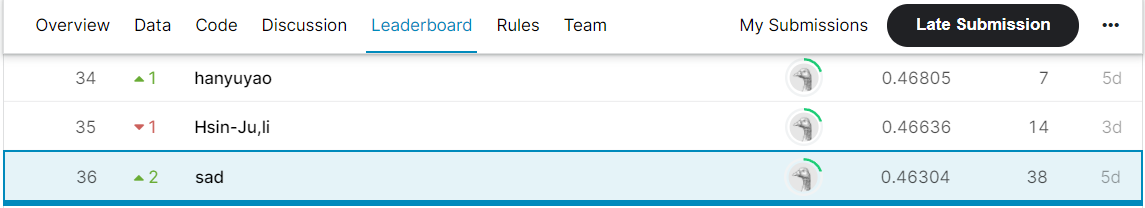

---

### Instructions

1. First: __This part is worth 30% of your grade.__ Do the **take home** exercises in the [DM2021-Lab2-master Repo](https://github.com/fhcalderon87/DM2021-Lab2-master). You may need to copy some cells from the Lab notebook to this notebook. 


2. Second: __This part is worth 30% of your grade.__ Participate in the in-class [Kaggle Competition](https://www.kaggle.com/c/dm2021-lab2-hw2/) regarding Emotion Recognition on Twitter. The scoring will be given according to your place in the Private Leaderboard ranking: 
    - **Bottom 40%**: Get 20% of the 30% available for this section.

    - **Top 41% - 100%**: Get (60-x)/6 + 20 points, where x is your ranking in the leaderboard (ie. If you rank 3rd your score will be (60-3)/6 + 20 = 29.5% out of 30%)   
    Submit your last submission __BEFORE the deadline (Dec. 24th 11:59 pm, Friday)__. Make sure to take a screenshot of your position at the end of the competition and store it as '''pic0.png''' under the **img** folder of this repository and rerun the cell **Student Information**.
    

3. Third: __This part is worth 30% of your grade.__ A report of your work developping the model for the competition (You can use code and comment it). This report should include what your preprocessing steps, the feature engineering steps and an explanation of your model. You can also mention different things you tried and insights you gained. 


4. Fourth: __This part is worth 10% of your grade.__ It's hard for us to follow if your code is messy :'(, so please **tidy up your notebook** and **add minimal comments where needed**.


Upload your files to your repository then submit the link to it on the corresponding e-learn assignment.

Make sure to commit and save your changes to your repository __BEFORE the deadline (Dec. 29th 11:59 pm, Wednesday)__. 

## 1. Data Preparation

## 1.1 Load data

1. data_identification: define which twitter ID are train and which one are test data(csv)
2. emotion: Label(Emotion) for train data(csv)
3. tweets_DM: data contain score, date hashtag, tweetid and text data from twitter(json)

In [1]:
import pandas as pd
pd.set_option('max_colwidth', 400)



from functools import partial

import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer



In [2]:
data_identification = pd.read_csv("data_identification.csv")
emotion = pd.read_csv("emotion.csv")

for json data we need to normalize (split it into seperate columns)

In [3]:
import json
tweets_DM = pd.read_json (r'tweets_DM.json',lines=True,orient='columns')
#normalize json data
data = tweets_DM['_source'].tolist()
df = pd.DataFrame.from_dict(pd.json_normalize(data), orient='columns')
tweets_DM= pd.concat([tweets_DM, df], axis=1)

Compress size for saving memory space

In [4]:
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% Compressed'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [5]:
tweets_DM = downcast(tweets_DM)
data_identification = downcast(data_identification)
emotion = downcast(emotion)

9.4% Compressed
0.0% Compressed
0.0% Compressed


In [6]:
data_identification

,tweet_id,identification
0,0x28cc61,test
1,0x29e452,train
2,0x2b3819,train
3,0x2db41f,test
4,0x2a2acc,train
...,...,...
1867530,0x227e25,train
1867531,0x293813,train
1867532,0x1e1a7e,train
1867533,0x2156a5,train


In [7]:
#rename column
tweets_DM= tweets_DM.rename(columns={'tweet.tweet_id': 'id', 'tweet.text': 'text','tweet.hashtags':'hashtags'})
#Drop unused columns
tweets_DM=tweets_DM.drop(['_source','_index','_type','_score', '_crawldate','hashtags'], axis=1)
data_identification= data_identification.rename(columns={'tweet_id': 'id'})
emotion= emotion.rename(columns={'tweet_id': 'id'})
#put it in new dataframe
Text = tweets_DM

Dividing train and test set data

In [8]:
traindata=data_identification[data_identification['identification']=='train']
traindata = pd.merge(traindata, Text,  how='left', left_on=['id'], right_on = ['id'])
traindata = pd.merge(traindata, emotion,  how='left', left_on=['id'], right_on = ['id'])
Testdata=data_identification[data_identification['identification']=='test']
Testdata = pd.merge(Testdata, Text,  how='left', left_on=['id'], right_on = ['id'])

print(traindata.shape)
print(Testdata.shape)

(1455563, 4)
(411972, 3)


In [9]:
# shuffle dataset
traindata = traindata.sample(frac=1)
Testdata = Testdata.sample(frac=1)
print(traindata.shape)
print(Testdata.shape)

(1455563, 4)
(411972, 3)


### 1.2 Save data

save data in Pickle format to continue without doing the previous step againn.

In [10]:
traindata.to_pickle("traindata.pkl")
Testdata.to_pickle("Testdata.pkl")

resume from saved file

In [11]:
import pandas as pd
traindata = pd.read_pickle("traindata.pkl")
Testdata = pd.read_pickle("Testdata.pkl")

Check if there is missing values in both train and test dataset

In [12]:
import helpers.data_mining_helpers as dmh
traindata.isnull().apply(lambda x: dmh.check_missing_values(x))

,id,identification,text,emotion
0,The amoung of missing records is:,The amoung of missing records is:,The amoung of missing records is:,The amoung of missing records is:
1,0,0,0,0


In [13]:
Testdata.isnull().apply(lambda x: dmh.check_missing_values(x))

,id,identification,text
0,The amoung of missing records is:,The amoung of missing records is:,The amoung of missing records is:
1,0,0,0


# 1.3 Cleaning text from tweet

see text lenght and words count for each tweet before cleaning

In [14]:
traindata['textlen'] = [len(t) for t in traindata['text']]
Testdata['textlen'] = [len(t) for t in Testdata['text']]
traindata['word_count'] = traindata['text'].apply(lambda x: len(str(x).split(" ")))
Testdata['word_count'] = Testdata['text'].apply(lambda x: len(str(x).split(" ")))

In [15]:
traindata

,id,identification,text,emotion,textlen,word_count
1117264,0x1d70f9,train,TS MOTHERFUCKING A <LH>,fear,23,4
1445686,0x2425d3,train,"@taylornation13 Thank you! Finally was able to snag the REP reversible sweatshirt, and a few other items. <LH>",trust,110,18
267791,0x300021,train,😏 Says they will sacrifice their life for <LH> tomorrow - 😢 can't give up #Bacon today. <LH>,anticipation,93,19
415029,0x2131a3,train,I’m going it!!!! <LH> of my own self. 💪🏽,trust,40,9
1013080,0x2f9252,train,"@Philippe_Tweets @seanhannity @DiamondandSilk 1 John 4:10 In this is #love, not that we <LH> #God, but that He <LH> us and sent [1/2]",joy,133,23
...,...,...,...,...,...,...
645335,0x2828cf,train,What if your healing comes through pain. #LauraStory <LH> <LH>,anticipation,62,10
724805,0x312ded,train,Suddenly feeling very <LH> about life 😀,sadness,39,7
880354,0x36197e,train,@TheHerd is on Jerry Jones's payroll....cowboys are nothing without elliott #cantadmityourwrong <LH> #speakthetruth,disgust,115,13
773762,0x33924a,train,$100 tip & I wasn't even planning on doing Uber tonight <LH> 🙌🏼🙏🏼🤑❤️,joy,68,13


Create Function to clean text from tweet

Because texts from tweets is too messy so i'll do some cleaning before doing EDA
These are the following steps that I do for text cleaning:

0. Replace emoticon with text
1. Replace emoji with text
2. Remove whitespace/url/mentions/hashtags/HTML/multiple letter/special letter
3. Lowercase
4. Replace contractions/slangs

For emoticon, contraction, and slang  I found a list of both things from github and I will use them to replace the original text(credit: https://github.com/Deffro/text-preprocessing-techniques/blob/master/techniques.py)

In [16]:
# defined emoticon
def load_dict_smileys():
    
    return {
        ":‑)":"smiley",
        ":-]":"smiley",
        ":-3":"smiley",
        ":->":"smiley",
        "8-)":"smiley",
        ":-}":"smiley",
        ":)":"smiley",
        ":]":"smiley",
        ":3":"smiley",
        ":>":"smiley",
        "8)":"smiley",
        ":}":"smiley",
        ":o)":"smiley",
        ":c)":"smiley",
        ":^)":"smiley",
        "=]":"smiley",
        "=)":"smiley",
        ":-))":"smiley",
        ":‑D":"smiley",
        "8‑D":"smiley",
        "x‑D":"smiley",
        "X‑D":"smiley",
        ":D":"smiley",
        "8D":"smiley",
        "xD":"smiley",
        "XD":"smiley",
        ":‑(":"sad",
        ":‑c":"sad",
        ":‑<":"sad",
        ":‑[":"sad",
        ":(":"sad",
        ":c":"sad",
        ":<":"sad",
        ":[":"sad",
        ":-||":"sad",
        ">:[":"sad",
        ":{":"sad",
        ":@":"sad",
        ">:(":"sad",
        ":'‑(":"sad",
        ":'(":"sad",
        ":‑P":"playful",
        "X‑P":"playful",
        "x‑p":"playful",
        ":‑p":"playful",
        ":‑Þ":"playful",
        ":‑þ":"playful",
        ":‑b":"playful",
        ":P":"playful",
        "XP":"playful",
        "xp":"playful",
        ":p":"playful",
        ":Þ":"playful",
        ":þ":"playful",
        ":b":"playful",
        "<3":"love"
        }

In [17]:
# defined contractions/slangs
def load_dict_contractions():
    
    return {
        "ain't":"is not",
        "amn't":"am not",
        "aren't":"are not",
        "can't":"cannot",
        "'cause":"because",
        "couldn't":"could not",
        "couldn't've":"could not have",
        "could've":"could have",
        "daren't":"dare not",
        "daresn't":"dare not",
        "dasn't":"dare not",
        "didn't":"did not",
        "doesn't":"does not",
        "don't":"do not",
        "e'er":"ever",
        "em":"them",
        "everyone's":"everyone is",
        "finna":"fixing to",
        "gimme":"give me",
        "gonna":"going to",
        "gon't":"go not",
        "gotta":"got to",
        "hadn't":"had not",
        "hasn't":"has not",
        "haven't":"have not",
        "he'd":"he would",
        "he'll":"he will",
        "he's":"he is",
        "he've":"he have",
        "how'd":"how would",
        "how'll":"how will",
        "how're":"how are",
        "how's":"how is",
        "I'd":"I would",
        "I'll":"I will",
        "I'm":"I am",
        "I'm'a":"I am about to",
        "I'm'o":"I am going to",
        "isn't":"is not",
        "it'd":"it would",
        "it'll":"it will",
        "it's":"it is",
        "I've":"I have",
        "kinda":"kind of",
        "let's":"let us",
        "mayn't":"may not",
        "may've":"may have",
        "mightn't":"might not",
        "might've":"might have",
        "mustn't":"must not",
        "mustn't've":"must not have",
        "must've":"must have",
        "needn't":"need not",
        "ne'er":"never",
        "o'":"of",
        "o'er":"over",
        "ol'":"old",
        "oughtn't":"ought not",
        "shalln't":"shall not",
        "shan't":"shall not",
        "she'd":"she would",
        "she'll":"she will",
        "she's":"she is",
        "shouldn't":"should not",
        "shouldn't've":"should not have",
        "should've":"should have",
        "somebody's":"somebody is",
        "someone's":"someone is",
        "something's":"something is",
        "that'd":"that would",
        "that'll":"that will",
        "that're":"that are",
        "that's":"that is",
        "there'd":"there would",
        "there'll":"there will",
        "there're":"there are",
        "there's":"there is",
        "these're":"these are",
        "they'd":"they would",
        "they'll":"they will",
        "they're":"they are",
        "they've":"they have",
        "this's":"this is",
        "those're":"those are",
        "'tis":"it is",
        "'twas":"it was",
        "wanna":"want to",
        "wasn't":"was not",
        "we'd":"we would",
        "we'd've":"we would have",
        "we'll":"we will",
        "we're":"we are",
        "weren't":"were not",
        "we've":"we have",
        "what'd":"what did",
        "what'll":"what will",
        "what're":"what are",
        "what's":"what is",
        "what've":"what have",
        "when's":"when is",
        "where'd":"where did",
        "where're":"where are",
        "where's":"where is",
        "where've":"where have",
        "which's":"which is",
        "who'd":"who would",
        "who'd've":"who would have",
        "who'll":"who will",
        "who're":"who are",
        "who's":"who is",
        "who've":"who have",
        "why'd":"why did",
        "why're":"why are",
        "why's":"why is",
        "won't":"will not",
        "wouldn't":"would not",
        "would've":"would have",
        "y'all":"you all",
        "you'd":"you would",
        "you'll":"you will",
        "you're":"you are",
        "you've":"you have",
        "Whatcha":"What are you",
        "luv":"love",
        "u":"you",
        "r":"are",
        "sux":"sucks",
        "2day":"today",
        "2nite":"tonight",
        "4u":"for you",
        "4ward":"forward",
        "a3":"anyplace, anywhere, anytime",
        "a/n":"author note",
        "a/w":"anyway",
        "a/s/l":"age, sex, location",
        "adn":"any day now",
        "afaic":"as far as i'm concerned",
        "afaik":"as far as I know",
        "afk":"away from keyboard",
        "aggro":"aggresive",
        "aight":"alright",
        "airhead":"stupid",
        "aka":"as known as",
        "alol":"actually laughing out loud",
        "amigo":"friend",
        "amz":"amazing",
        "app":"application",
        "armpit":"undesirable",
        "asap":"as soon as possible",
        "atm":"at the moment",
        "atw":"all the way",
        "b/c":"because",
        "b-day":"birthday",
        "b4":"before",
        "b4n":"bye for now",
        "bae":"before anyone else",
        "bak":"back at the keyboard",
        "bbl":"bee back later",
        "bday":"birthday",
        "becuz":"because",
        "bent":"angry",
        "bestie":"best friend",
        "besty":"best friend",
        "bf":"boyfriend",
        "bff":"best friends forever",
        "bffe":"best friends forever",
        "bfn":"bye for now",
        "bg":"big grin",
        "bmfe":"best mates forever",
        "bmfl":"best mates life",
        "bozo":"idiot",
        "brah":"friend",
        "bravo":"well done",
        "brb":"be right back",
        "bro":"brother",
        "bta":"but then again",
        "btdt":"been there, done that",
        "btr":"better",
        "btw":"by the way",
        "buddy":"friend",
        "c'mon":"came on",
        "cid crying in disgrace":"",
        "congrats congratulations":"",
        "copacetic excellent":"",
        "coz beacause":"",
        "cu":"see you",
        "cuddy":"friends",
        "cul":"see you later",
        "cul8r":"see you later ",
        "cutie":"cute",
        "cuz":"because",
        "cya":"bye",
        "cyo":"see you online ",
        "dbau":"doing business as usual",
        "deets":"details",
        "dmn":"damn",
        "dobe":"idiot",
        "dope":"stupid",
        "dork":"strange",
        "dunno":"don't know",
        "dwi":"deal with it",
        "dyd":"don't you dare",
        "ermahgerd":"oh my gosh",
        "eu":"europe",
        "ez":"easy",
        "f9":"fine",
        "fav":"favorite",
        "far-out":"great",
        "fb":"facebook",
        "flick":"movie",
        "fml":"fuck my life",
        "foxy":"sexy",
        "friggin":"freaking",
        "fttn":"for the time being",
        "ftw":"for the win",
        "fud":"fear, uncertainty, and doubt",
        "fwiw":"for what it's worth ",
        "fyi":"for your information",
        "g":"grin ",
        "g2g":"got to go ",
        "ga":"go ahead ",
        "gal":"get a life",
        "getcha":"understand ",
        "gf":"girlfriend ",
        "gfn":"gone for now",
        "gg":"good game",
        "gj":"good job",
        "gky":"go kill yourself",
        "gl":"good luck",
        "glhf":"good luck have fun",
        "gmab":"give me a break",
        "gmbo":"giggling my butt off ",
        "gmta":"great minds think alike ",
        "goof":"idiot",
        "goofy":"idiot",
        "gr8":"great",
        "gtg":"got to go",
        "gud":"good",
        "h8":"hate",
        "hagn":"have a good night ",
        "hdop":"help delete online predators ",
        "hf":"have fun",
        "hml":"hate my life",
        "hoas":"hold on a second",
        "hhis":"hanging head in shame ",
        "hmu":"hit me up",
        "hru":"how are you",
        "twt":"hope this helps",
        "hw":"homework",
        "im":"i am",
        "i'ma":"i am going to",
        "iac":"in any case ",
        "ic":"I see ",
        "icymi":"in case you missed it",
        "idk":"I don't know",
        "iggy":"ignore ",
        "iht":"i hate this",
        "ikr":"i know, right?",
        "ilt":"i like that",
        "ily":"i love you",
        "ima":"i am going to ",
        "imao":"in my arrogant opinion",
        "imnsho":"in my not so humble opinion ",
        "imo":"in my opinion ",
        "imy":"i miss you",
        "iou":"i owe you",
        "iow":"in other words ",
        "ipn":"I’m posting naked ",
        "irl":"in real life ",
        "j/k":"just kidding",
        "jdi":"just do it",
        "jk":"just kidding",
        "jkn":"joking",
        "jyeah":"yeah",
        "kinda":"kind of",
        "l8":"late",
        "l8r":"later",
        "lbh":"let's be honest",
        "ld":"later, dude",
        "ldi":"let's do it  ",
        "ldr":"long distance relationship ",
        "lees":"beautiful ",
        "lfm":"looking for more",
        "lil":"little",
        "llta":"lots and lots of thunderous applause ",
        "lmao":"laugh my ass off",
        "lmirl":"let's meet in real life ",
        "lmk":"let me know",
        "lol":"laugh out loud",
        "lolz":"laugh out loud",
        "lotta":"lot of",
        "lsr":"loser",
        "ltr":"longterm relationship",
        "lua":"love you always ",
        "lub":"love",
        "lubb":"love",
        "lulab":"love you like a brother ",
        "lulas":"love you like a sister ",
        "lul":"laugh",
        "luls":"laugh",
        "lulz":"laugh",
        "lumu":"love you miss you",
        "luv":"love",
        "lux":"luxury",
        "lwm":"laugh with me",
        "lwp":"laugh with passion",
        "lvl":"level",
        "m/f":"male or female",
        "m2":"me too",
        "m8":"mate",
        "me2":"me too",
        "milf":"mother I would like to fuck",
        "mma":"meet me at",
        "mmb":"message me back",
        "mvp":"most valueable player",
        "msg":"message",
        "mtf":"more to follow",
        "myob":"mind your own business",
        "nah":"no",
        "nc":"no comment",
        "nk":"not kidding",
        "ngl":"not gonna lie",
        "nlt":"no later than",
        "nm":"not much",
        "no1":"no one",
        "np":"no problem",
        "nsfw":"not safe for work",
        "nuh":"no",
        "nvm":"nevermind",
        "obo":"or best offer",
        "oic":"oh, i see",
        "oll":"online love ",
        "omg":"oh my god",
        "omw":"on my way",
        "osm":"awesome",
        "otoh":"on the other hand ",
        "perv":"pervert",
        "pervy":"pervert",
        "phat":"pretty hot and tempting",
        "pir":"parent in room",
        "pls":"please",
        "plz":"please",
        "ppl":"people",
        "pro":"professional",
        "pwnd":"owned",
        "qq":"crying",
        "r":"are",
        "rly":"really",
        "rofl":"roll on the floor laughing",
        "rolf":"roll on the floor laughing",
        "rpg":"role playing games",
        "ru":"are you",
        "s2u":"shame to you",
        "scrub":"loser",
        "sec":"second",
        "shid":"slaps head in disgust",
        "shoulda":"should have",
        "sff":"so funny",
        "smexy":"smart and sexy",
        "smh":"shaking my head",
        "somy":"sick of me yet",
        "sot":"short of time ",
        "sry":"sorry",
        "str8":"straight",
        "sux":"sucks",
        "swag":"style",
        "taze":"irritate",
        "tba":"to be announced",
        "tbfu":"too bad for you",
        "tbc":"to be continued",
        "tbd":"to be determined",
        "tbr":"to be rude",
        "tc":"take care",
        "thx":"thanks",
        "thanx":"thanks",
        "thx":"thanks",
        "tfw":"that feeling  when",
        "til":"today i learned",
        "ttyl":"talk to you later ",
        "ty":"thank you",
        "tyvm":"thank you very much",
        "u":"you",
        "uber":"the best",
        "ugh":"disgusted",
        "ur":"you are",
        "uw":"you are welcome ",
        "vs":"versus",
        "w2f":"way too funny",
        "w8":"wait",
        "wak":"weird",
        "wanna":"want to",
        "wb":"welcome back",
        "whiz":"talented",
        "whoa":"surprise",
        "whoah":"surprise",
        "wfm":"works for me ",
        "wibni":"wouldn't it be nice if ",
        "wmd":"weapon of mass destruction",
        "wot":"what",
        "wtf":"what the fuck",
        "wtg":"way to go",
        "wtgp":"want to go private",
        "wu":"what's up",
        "wuh":"what?",
        "wuv":"love",
        "ym":"young man",
        "yawn":"boring",
        "yum":"good",
        "x":"kiss",
        "xxx":"kiss",
        "xdd":"laughing",
        "y":"why",
        "yolo":"you only live once",
        "yuge":"huge",
        "yw":"you are welcome",
        "ywa":"you are welcome anyway",
        "zomg":"oh my god!",
        "zzz":"sleeping"    
        }

In [18]:
#replace emoticon with words in the dictionary
emoticon=load_dict_smileys()
def demoticon(text):
    text = text.replace("’","'")
    words = text.split()
    text = [emoticon[text] if text in emoticon else text for text in words]
    text = " ".join(text)
    return text

In [19]:
import emoji
from emoji import emojize
# add space before and after the emoji
from emoji import UNICODE_EMOJI
def is_emoji(s, language="en"):
    return s in UNICODE_EMOJI[language]
def add_space(text):
    return ''.join(' ' + char + ' 'if is_emoji(char) else char for char in text).strip()

In [20]:
#replace emoji using emoji library
def demoji(text):
    text = emoji.demojize(text, delimiters=("", " "))  
    return text

In [21]:
#clean noisy data
import re
import itertools
def cleaning_text(text):    
    text = text.strip() # remove white space
    text = re.sub(r'http\S+', "", text)    # remove urls
    text = re.sub(r'@\w+','',text)         # remove mentions
    text = re.sub(r'#', '', text)       # remove hastags \w+
    text = re.sub(r'<\w+','', text)       # remove html tags
    text = re.sub(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});', '', text) 
    text = re.sub(r'>', '', text)
    text = ''.join(''.join(s)[:2] for _, s in itertools.groupby(text)) # remove multiple letters
    text = text.lower()  #convert to lower case
    text = re.sub('[!,*)@#%(&$_?.^+->:;/\"]', '', text)
    return text

In [22]:
#replace the contractions
CONTRACTIONS=load_dict_contractions()
def replaceconslang(text):
    text = text.replace("’","'")
    words = text.split()
    text = [CONTRACTIONS[text] if text in CONTRACTIONS else text for text in words]
    text = " ".join(text)
    text =re.sub('[^a-zA-Z0-9 \n\.]', '', text)
    return text

Apply function to dataframe & insert into new column

In [23]:
%%time
traindata['cleantext']=traindata['text'].apply(lambda x: demoticon(x))
Testdata['cleantext']=Testdata['text'].apply(lambda x: demoticon(x))
traindata['cleantext']=traindata['cleantext'].apply(lambda x: add_space(x))
Testdata['cleantext']=Testdata['cleantext'].apply(lambda x: add_space(x))
traindata['cleantext']=traindata['cleantext'].apply(lambda x: demoji(x))
Testdata['cleantext']=Testdata['cleantext'].apply(lambda x: demoji(x))
traindata['cleantext']=traindata['cleantext'].apply(lambda x: cleaning_text(x))
Testdata['cleantext']=Testdata['cleantext'].apply(lambda x: cleaning_text(x))
traindata['cleantext']=traindata['cleantext'].apply(lambda x: replaceconslang(x))
Testdata['cleantext']=Testdata['cleantext'].apply(lambda x: replaceconslang(x))

Wall time: 15min 24s


In [24]:
traindata['textlenafter']=[len(t) for t in traindata['cleantext']]
traindata['word_countafter'] = traindata['cleantext'].apply(lambda x: len(str(x).split(" ")))

In [25]:
traindata

,id,identification,text,emotion,textlen,word_count,cleantext,textlenafter,word_countafter
1117264,0x1d70f9,train,TS MOTHERFUCKING A <LH>,fear,23,4,ts motherfucking a,18,3
1445686,0x2425d3,train,"@taylornation13 Thank you! Finally was able to snag the REP reversible sweatshirt, and a few other items. <LH>",trust,110,18,thank you finally was able to snag the rep reversible sweatshirt and a few other items,86,16
267791,0x300021,train,😏 Says they will sacrifice their life for <LH> tomorrow - 😢 can't give up #Bacon today. <LH>,anticipation,93,19,smirkingface says they will sacrifice their life for tomorrow cryingface cannot give up bacon today,99,15
415029,0x2131a3,train,I’m going it!!!! <LH> of my own self. 💪🏽,trust,40,9,im going it of my own self flexedbiceps mediumskintone,54,9
1013080,0x2f9252,train,"@Philippe_Tweets @seanhannity @DiamondandSilk 1 John 4:10 In this is #love, not that we <LH> #God, but that He <LH> us and sent [1/2]",joy,133,23,john in this is love not that we god but that he us and sent,61,16
...,...,...,...,...,...,...,...,...,...
645335,0x2828cf,train,What if your healing comes through pain. #LauraStory <LH> <LH>,anticipation,62,10,what if your healing comes through pain laurastory,50,8
724805,0x312ded,train,Suddenly feeling very <LH> about life 😀,sadness,39,7,suddenly feeling very about life grinningface,45,6
880354,0x36197e,train,@TheHerd is on Jerry Jones's payroll....cowboys are nothing without elliott #cantadmityourwrong <LH> #speakthetruth,disgust,115,13,is on jerry joness payrollcowboys are nothing without elliott cantadmityourwrong speakthetruth,94,11
773762,0x33924a,train,$100 tip & I wasn't even planning on doing Uber tonight <LH> 🙌🏼🙏🏼🤑❤️,joy,68,13,tip i was not even planning on doing the best tonight raisinghands mediumlightskintone foldedhands mediumlightskintone moneymouthface redheart,142,17


i tried English Language Detection use fasttext

In [26]:
import fasttext
pretrained_model = "lid.176.bin" 
model = fasttext.load_model(pretrained_model)
langs = []
for sent in traindata['cleantext']:
    lang = model.predict(sent)[0]
    langs.append(str(lang)[:])
traindata['langs'] = langs

In [27]:
traindata[~traindata["langs"].str.contains('en')]

,id,identification,text,emotion,textlen,word_count,cleantext,textlenafter,word_countafter,langs
163189,0x34d498,train,@_erxse Congrats <LH>,trust,21,3,congrats,8,1,"('__label__fr',)"
1390022,0x3187c8,train,"""World peace""? <LH> #BB19",disgust,25,4,world peace bb,14,3,"('__label__ja',)"
517466,0x32a4fa,train,#WIU IM DJ'N THE RITZ AGAIN TONIGHT ‼️ 10PM-1AM <LH> 🙏🏼,joy,58,14,wiu i am djn the ritz again tonight doubleexclamationmark pmam foldedhands mediumlightskintone,94,12,"('__label__nl',)"
1069816,0x31c1fe,train,I’m n the Laguna for Thanksgiving Wassup <LH>,trust,46,9,im n the laguna for thanksgiving wassup,39,7,"('__label__de',)"
835609,0x372f04,train,@reidermeister I know ha. <LH>,sadness,30,5,i know ha,9,3,"('__label__ia',)"
...,...,...,...,...,...,...,...,...,...,...
863875,0x26febc,train,I'm goin up the country😎 #life <LH> <LH> <LH> <LH>,joy,51,11,im goin up the country smilingfacewithsunglasses life,53,7,"('__label__de',)"
1012031,0x242514,train,Mis nenas me llamaron por FaceTime and I'm so happy <LH> 😭☺️,joy,60,12,mis nenas me llamaron por facetime and im so happy loudlycryingface smilingface,79,12,"('__label__es',)"
485580,0x33b52c,train,#GiveEmmaAChance #emmastartedtherevolution <LH> toseeyougo @EmmaWWE,sadness,67,5,giveemmaachance emmastartedtherevolution toseeyougo,51,3,"('__label__fi',)"
532671,0x27d474,train,i’m so in love w sam. it’s unreal <LH>,joy,38,9,im so in love w sam it is unreal,32,9,"('__label__de',)"


But sometimes it detect english sentence to be in other language so I didn't remove these records

Check for Null and remove duplicated value

In [28]:
traindata[traindata.isna().any(axis=1)]

,id,identification,text,emotion,textlen,word_count,cleantext,textlenafter,word_countafter,langs


In [29]:
traindata[traindata.duplicated(['cleantext'], keep=False)]

,id,identification,text,emotion,textlen,word_count,cleantext,textlenafter,word_countafter,langs
1013080,0x2f9252,train,"@Philippe_Tweets @seanhannity @DiamondandSilk 1 John 4:10 In this is #love, not that we <LH> #God, but that He <LH> us and sent [1/2]",joy,133,23,john in this is love not that we god but that he us and sent,61,16,"('__label__en',)"
163189,0x34d498,train,@_erxse Congrats <LH>,trust,21,3,congrats,8,1,"('__label__fr',)"
317265,0x2e7490,train,Book is Knowledge Mankind CALLS OUT fouseyTUBE | <LH> 😭,surprise,58,13,book is knowledge mankind calls out fouseytube loudlycryingface,64,9,"('__label__en',)"
182159,0x35de7b,train,"@melidanygaards5 #faith, #hope, and <LH> will last forever. The greatest is #love. 1 corinthians 13:13 <LH>",joy,107,16,faith hope and will last forever the greatest is love corinthians,65,11,"('__label__en',)"
1322502,0x2a5e78,train,"Closed Sell 1.0 Lots EURUSD 1.18411 for +26.0 pips, total for today +2234.3 pips <LH> <LH> <LH> <LH> <LH>",joy,105,19,closed sell lots eurusd for pips total for today pips,53,10,"('__label__en',)"
...,...,...,...,...,...,...,...,...,...,...
1260169,0x1dc830,train,@dave262london Thank you <LH>,trust,29,4,thank you,9,2,"('__label__en',)"
1080451,0x351255,train,"Closed Buy 1.0 Lots EURUSD 1.18035 for +25.1 pips, total for today +354.4 pips <LH> <LH> <LH> <LH> <LH>",joy,103,19,closed buy lots eurusd for pips total for today pips,52,10,"('__label__en',)"
1405473,0x214673,train,@TeenChoiceFOX @bts_bighit @BTS_twt My #TeenChoice <LH> #ChoiceInternationalArtist is BTS @BTS_twt @TeenChoiceFOX,anticipation,113,11,my teenchoice choiceinternationalartist is bts,46,5,"('__label__en',)"
744360,0x231822,train,Love is love's reward. ~John Dryden <LH> <LH>,joy,45,8,love is loves reward john dryden,32,6,"('__label__en',)"


In [30]:
traindata.drop_duplicates('cleantext', keep='first',inplace=True)

In [31]:
traindata.shape

(1346311, 10)

save data in Pickle format to continue without doing the previous step againn.

In [32]:
traindata.to_pickle("traindataclean.pkl")
Testdata.to_pickle("Testdataclean.pkl")

# 1.4 Exploratory Data Analysis

continue from save file

In [33]:
import pandas as pd
traindata = pd.read_pickle("traindataclean.pkl")
Testdata = pd.read_pickle("Testdataclean.pkl")

let see the result from out cleaning process

In [34]:
from collections import Counter
result = Counter(" ".join(traindata['text'].values.tolist()).split(" ")).items()
print("Number of unique words before:",len(result))
result = Counter(" ".join(traindata['cleantext'].values.tolist()).split(" ")).items()
print("Number of unique words after:",len(result))

Number of unique words before: 1575335
Number of unique words after: 528831


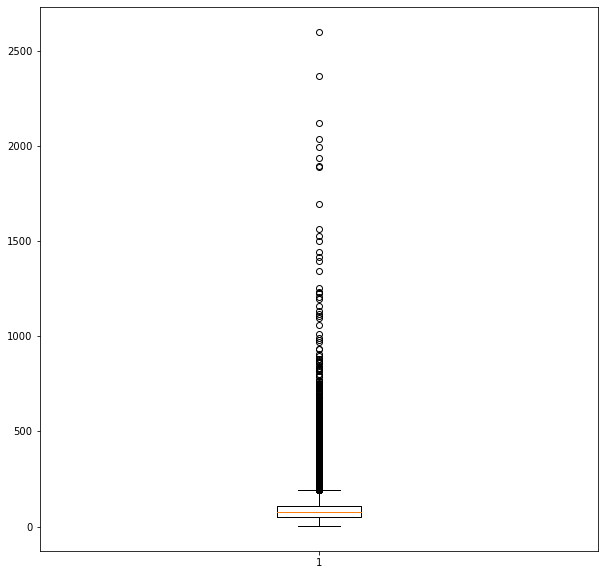

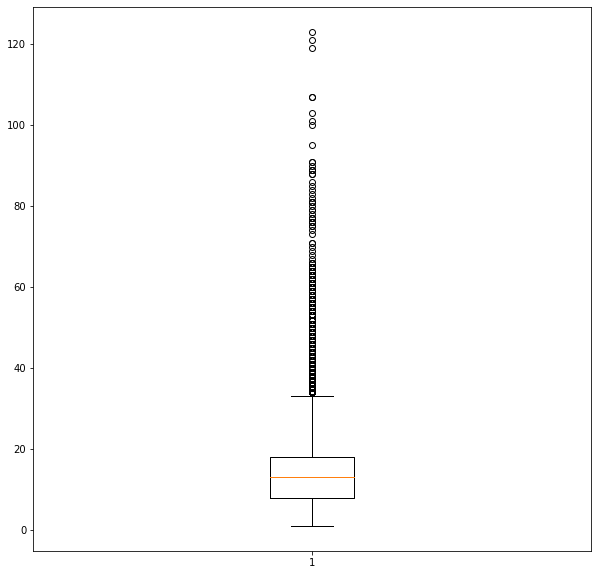

In [35]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
plt.boxplot(traindata.textlenafter)
plt.show()

fig, ax = plt.subplots(figsize=(10, 10))
plt.boxplot(traindata.word_countafter)
plt.show()

There is many outlier so let see.

In [36]:
traindata[traindata['word_countafter']>40]
traindata=traindata.drop(traindata[(traindata.word_countafter>70)].index)

## Wordcloud Visualization

see the word frequency for every emotion

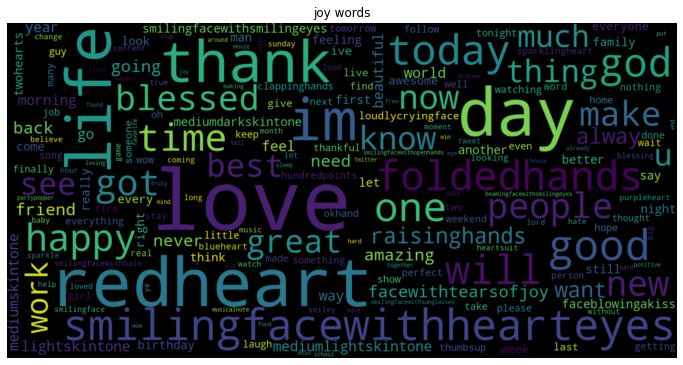

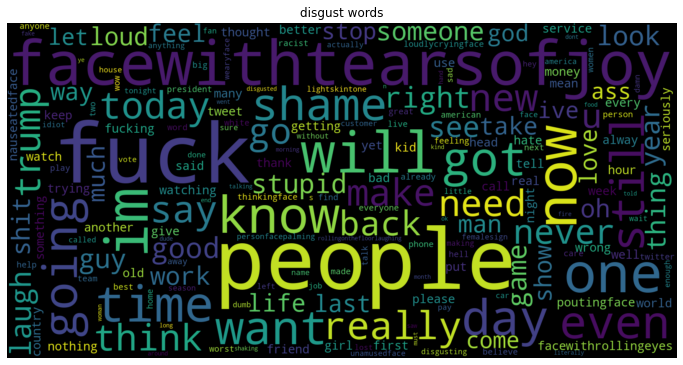

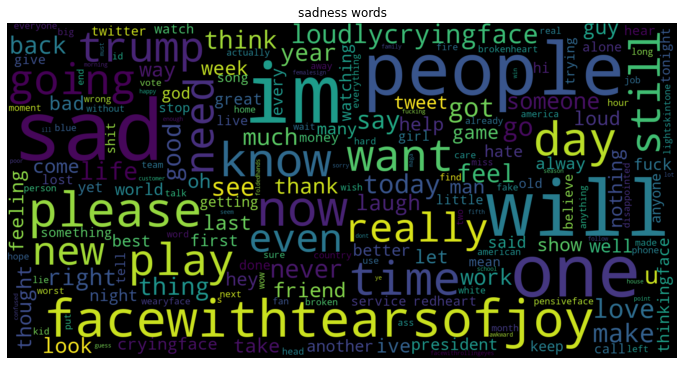

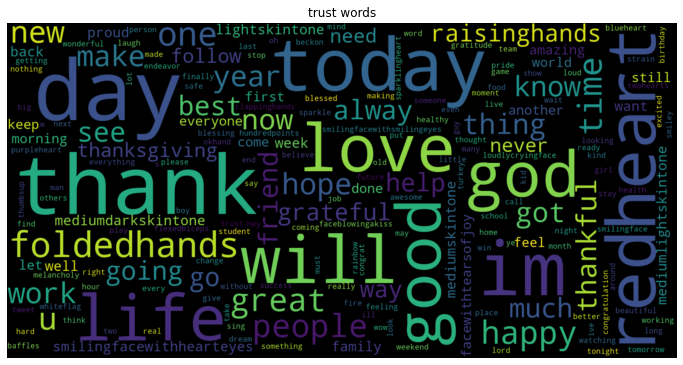

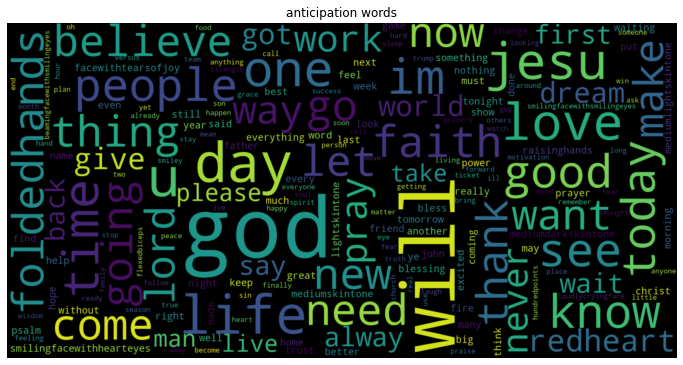

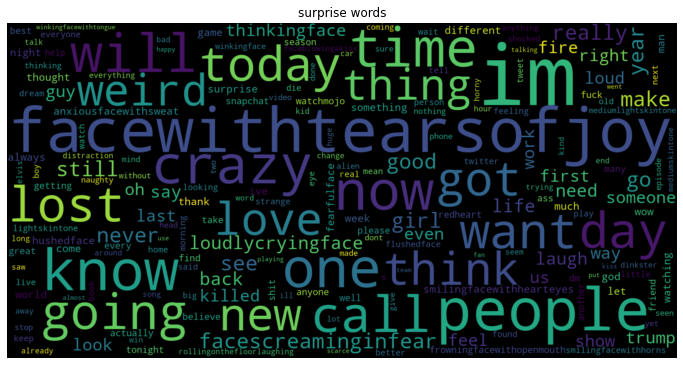

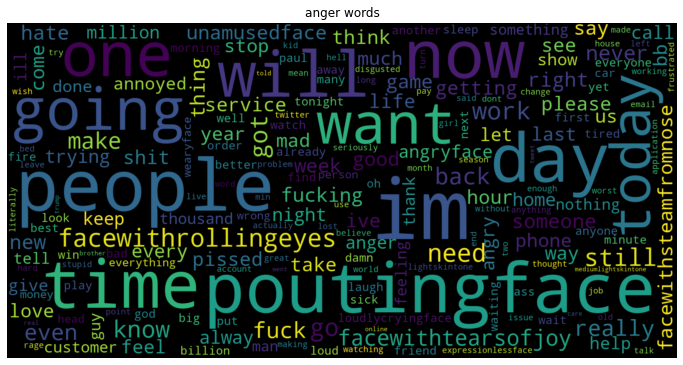

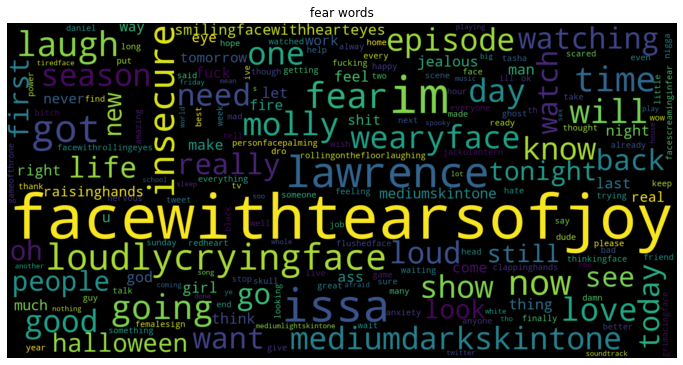

In [37]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud
joy_tweets = traindata[traindata.emotion == 'joy']
joy_string = []
for t in joy_tweets.cleantext:
    joy_string.append(t)
joy_string = pd.Series(joy_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,collocations=False).generate(joy_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("joy words")
plt.show()

disgust_tweets = traindata[traindata.emotion == 'disgust']
disgust_string = []
for t in disgust_tweets.cleantext:
    disgust_string.append(t)
disgust_string = pd.Series(disgust_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,collocations=False).generate(disgust_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("disgust words")
plt.show()

sadness_tweets = traindata[traindata.emotion == 'sadness']
sadness_string = []
for t in sadness_tweets.cleantext:
    sadness_string.append(t)
sadness_string = pd.Series(sadness_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,collocations=False).generate(sadness_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("sadness words")
plt.show()

trust_tweets = traindata[traindata.emotion == 'trust']
trust_string = []
for t in trust_tweets.cleantext:
    trust_string.append(t)
trust_string = pd.Series(trust_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,collocations=False).generate(trust_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("trust words")
plt.show()

anticipation_tweets = traindata[traindata.emotion == 'anticipation']
anticipation_string = []
for t in anticipation_tweets.cleantext:
    anticipation_string.append(t)
anticipation_string = pd.Series(anticipation_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,collocations=False).generate(anticipation_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("anticipation words")
plt.show()

surprise_tweets = traindata[traindata.emotion == 'surprise']
surprise_string = []
for t in surprise_tweets.cleantext:
    surprise_string.append(t)
surprise_string = pd.Series(surprise_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,collocations=False).generate(surprise_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("surprise words")
plt.show()

anger_tweets = traindata[traindata.emotion == 'anger']
anger_string = []
for t in anger_tweets.cleantext:
    anger_string.append(t)
anger_string = pd.Series(anger_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,collocations=False).generate(anger_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("anger words")
plt.show()

fear_tweets = traindata[traindata.emotion == 'fear']
fear_string = []
for t in fear_tweets.cleantext:
    fear_string.append(t)
fear_string = pd.Series(fear_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,collocations=False).generate(fear_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("fear words")
plt.show()

drop text that have less than 2 words and texlen morethan 50

In [38]:
traindata=traindata.drop(traindata[(traindata.word_countafter<3)& (traindata.textlenafter > 50)].index)

see the distribution between each emotion

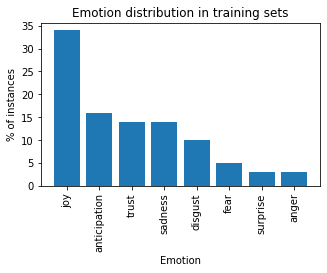

In [39]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# the histogram of the data
labels = traindata['emotion'].unique()
post_total = len(traindata)
df1 = traindata['emotion'].value_counts()
df1 = df1.apply(lambda x: round(x*100/post_total))

#plot
fig, ax = plt.subplots(figsize=(5,3))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution in training sets')
plt.grid(False)
plt.xticks(rotation=90)
plt.show()

the data is highly imbalance so i'll try to upsampling later to see if the model will perform better

# 2. Feature engineering

I split the data for training and testing the model

In [40]:
from sklearn.model_selection import train_test_split
X = traindata.cleantext
y = traindata.emotion
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 42)

see the distribution between train&test dataset

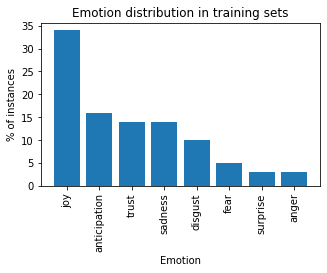

In [41]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# the histogram of the data
labels = y_train.unique()
post_total = len(y_train)
df1 = y_train.value_counts()
df1 = df1.apply(lambda x: round(x*100/post_total))

#plot
fig, ax = plt.subplots(figsize=(5,3))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution in training sets')
plt.grid(False)
plt.xticks(rotation=90)
plt.show()

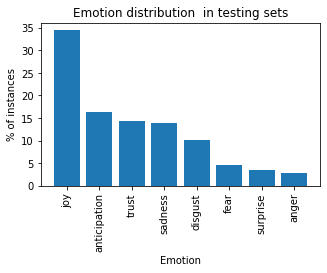

In [42]:
# the histogram of the data
labels = y_test.unique()
post_total = len(y_test)
df1 = y_test.value_counts()
df1 = df1.apply(lambda x: round(x*100/post_total,3))

#plot
fig, ax = plt.subplots(figsize=(5,3))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution  in testing sets')
plt.grid(False)
plt.xticks(rotation=90)
plt.show()

## 2.1 Bag of word (countvectorizer)

In [43]:
from sklearn.feature_extraction.text import CountVectorizer
BOW_vectorizer = CountVectorizer(stop_words='english') 
BOW_vectorizer.fit(X_train)
train_data_vectorizer_features=BOW_vectorizer.transform(X_train)

## 2.2 Tfidfvertorizer

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
Tfidfvertorizer = TfidfVectorizer(stop_words = "english")
train_data_Tfidf_features = Tfidfvertorizer.fit_transform(X_train)

## 2.3 nltktokenizer

In [45]:
from nltk.tokenize import  word_tokenize
word_tokenize = CountVectorizer(tokenizer = word_tokenize,stop_words='english')
train_data_tweet_features = word_tokenize.fit_transform(X_train)

# 3 Model&Evaluation

## 3.1 Naive Bayes Classifier

Naive Bayes (NB) is a common model for document classification. The main concept of Naive Bayes is to use the Bayes’ Theorem to estimate the joint probability of all the different words conditioned on each label.

after trying every tokenizer I found that countvect with default tokenizer gave me the best resut so I use it

In [46]:
allemo = ['joy','sadness','trust','anticipation','disgust','surprise','anger','fear']

In [47]:
%%time
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
nb = Pipeline([('vect', BOW_vectorizer),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)


from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=allemo))

accuracy 0.5022881935157945
              precision    recall  f1-score   support

         joy       0.83      0.07      0.12      3736
     sadness       0.58      0.45      0.51     22059
       trust       0.45      0.35      0.39     13654
anticipation       0.78      0.22      0.35      6224
     disgust       0.49      0.83      0.62     46366
    surprise       0.44      0.44      0.44     18675
       anger       0.81      0.11      0.19      4702
        fear       0.56      0.22      0.31     19188

    accuracy                           0.50    134604
   macro avg       0.62      0.34      0.37    134604
weighted avg       0.54      0.50      0.47    134604

Wall time: 24 s


In [48]:
%%time
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
nb = Pipeline([('vect', Tfidfvertorizer),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)


from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=allemo))

accuracy 0.44619030638019674
              precision    recall  f1-score   support

         joy       0.99      0.04      0.08      3736
     sadness       0.70      0.29      0.41     22059
       trust       0.63      0.12      0.20     13654
anticipation       0.97      0.09      0.16      6224
     disgust       0.40      0.96      0.57     46366
    surprise       0.52      0.26      0.35     18675
       anger       0.98      0.07      0.14      4702
        fear       0.79      0.08      0.15     19188

    accuracy                           0.45    134604
   macro avg       0.75      0.24      0.26    134604
weighted avg       0.61      0.45      0.37    134604

Wall time: 24.4 s


In [49]:
%%time
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
nb = Pipeline([('vect', word_tokenize),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)


from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=allemo))

accuracy 0.5022733351163413
              precision    recall  f1-score   support

         joy       0.84      0.07      0.12      3736
     sadness       0.58      0.45      0.51     22059
       trust       0.45      0.35      0.39     13654
anticipation       0.78      0.22      0.35      6224
     disgust       0.49      0.83      0.62     46366
    surprise       0.44      0.44      0.44     18675
       anger       0.81      0.11      0.19      4702
        fear       0.56      0.22      0.31     19188

    accuracy                           0.50    134604
   macro avg       0.62      0.34      0.37    134604
weighted avg       0.54      0.50      0.47    134604

Wall time: 2min 12s


--------------------------------------------------------------

# 3.2 SGDClassifier

In [50]:
%%time
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer(stop_words='english')),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=10, tol=None)),
               ])
sgd.fit(X_train, y_train)



y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=allemo))

accuracy 0.4882098600338772
              precision    recall  f1-score   support

         joy       0.37      0.18      0.24      3736
     sadness       0.50      0.46      0.48     22059
       trust       0.46      0.31      0.37     13654
anticipation       0.60      0.29      0.39      6224
     disgust       0.49      0.82      0.61     46366
    surprise       0.47      0.35      0.40     18675
       anger       0.41      0.18      0.25      4702
        fear       0.49      0.18      0.26     19188

    accuracy                           0.49    134604
   macro avg       0.47      0.35      0.38    134604
weighted avg       0.48      0.49      0.46    134604

Wall time: 51.4 s


--------------------------------------------

# 3.3 LogisticRegression

In [66]:
%%time
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer(stop_words='english')),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)



y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=allemo))

C:\Users\Ae\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy 0.5024887819084128
              precision    recall  f1-score   support

         joy       0.51      0.18      0.27      3736
     sadness       0.59      0.42      0.50     22059
       trust       0.43      0.36      0.40     13654
anticipation       0.64      0.32      0.43      6224
     disgust       0.50      0.79      0.61     46366
    surprise       0.46      0.40      0.43     18675
       anger       0.52      0.20      0.29      4702
        fear       0.48      0.30      0.36     19188

    accuracy                           0.50    134604
   macro avg       0.52      0.37      0.41    134604
weighted avg       0.51      0.50      0.48    134604

Wall time: 2min 40s


In [67]:
PRED= logreg.predict(Testdata['cleantext'])

In [68]:
Testdata['emotion']=PRED

In [69]:
Testdata

,id,identification,text,textlen,word_count,cleantext,emotion
143593,0x2569f7,test,"I must not leave it to be supposed that we were ever a great House, or who's the one that should be in jail!# <LH>",114,25,i must not leave it to be supposed that we were ever a great house or who is the one that should be in jail,sadness
130896,0x33443a,test,My other question for #FlatEarth conspiracy theorists is... Why? Who would keep that a secret? To what end? Who gains? #flatearthers <LH>,137,22,my other question for flatearth conspiracy theorists is why who would keep that a secret to what end who gains flatearthers,anticipation
149453,0x34f384,test,when U put your arm around his waist & it feels comforting over the years & then that moment you do it & find he's wasting away <LH>,132,28,when you put your arm around his waist it feels comforting over the years then that moment you do it find he is wasting away,sadness
201204,0x2b8d67,test,Dont take your good health today for granted. Take proper care of your body. #weekendtip <LH> #s4s,99,17,dont take your good health today for granted take proper care of your body weekendtip ss,trust
3458,0x34e19d,test,"@gmanetwork @leysam1 Wow, quick edit pa more😂😂😂 #TooLate <LH>",62,10,wow quick edit pa more facewithtearsofjoy facewithtearsofjoy facewithtearsofjoy toolate,disgust
...,...,...,...,...,...,...,...
384246,0x20d470,test,Texans Remember This: BOTH Sen @JohnCornyn & @tedcruz voted to TAKE AWAY health insurance for millions of Texans! #SkinnyRepeal <LH>,132,20,texans remember this both sen voted to take away health insurance for millions of texans skinnyrepeal,disgust
365613,0x340f22,test,There is no such thing as impossibility in God's dictionary. God can do all things and do them perfectly. #TheRestingPlace <LH>,127,21,there is no such thing as impossibility in gods dictionary god can do all things and do them perfectly therestingplace,joy
257353,0x29aebd,test,@settermjd Both cases suck!!! False docs maybe worse <LH>,57,9,both cases suck false docs maybe worse,disgust
407114,0x26d77a,test,"I desperately need my faced glazed with black man cum, I'll get on all fours and beg for it in public if i have to! <LH> #faggot",128,27,i desperately need my faced glazed with black man cum ill get on all fours and beg for it in public if i have to faggot,fear


In [70]:
Testdata[['id','emotion']].to_csv('LR.csv', sep=',', encoding='utf-8')

# 3.4 FASTTEXT(Best score)

Format data & export to TXT because fasttext read data from text file

In [71]:
hyper_params = {"lr": 0.01,
                "epoch": 14,
                "wordNgrams": 2,
                "dim": 20}    

In [72]:
traindata['data'] = traindata['cleantext']+'__label__'+traindata['emotion']

In [73]:
traindata['data'].to_csv('fastnotokay1.txt')

Trainmodel&evaluate

In [74]:
import fasttext

In [75]:
model = fasttext.train_supervised('fastnotokay1.txt',**hyper_params)
print("Model trained with the hyperparameter \n {}".format(hyper_params))

Model trained with the hyperparameter 
 {'lr': 0.01, 'epoch': 14, 'wordNgrams': 2, 'dim': 20}


In [76]:
traindata['cleantext'][1]

'yoo we hit all our monthly goals with the new application in two weeks spateradio application'

In [77]:
model.predict(traindata['cleantext'][1])

(('__label__joy',), array([0.32927334]))

Evaluate kaggle test dataset

In [78]:
Testdata['emotion'] = Testdata['cleantext'].apply(lambda x: model.predict(x))

In [79]:
Testdata[['id','emotion']].to_csv('FAST22ngram.csv', sep=',', encoding='utf-8')

------------------------------------------------

# Conclusion
## Insights gained.

- between these models I tried, I foud that Fasttext give me the best result on the competition with very fast training time 
- text from twitter are really messy so the text cleaning is very important (I go back many times to do the text cleaning)
- this case BOW is better than Tfidf, may be the frequent word is really help us to classify but idf removed it.(at first I think TFIDF would perform better)

# Things I want to improve/try

- other language models like bert(I've tried roberta but my computer keep dying & the estimated time train are 10 days ;(
- try upsampling/other method to deal with the data imbalance.Because the majority of the data labels are 'joy,' so the model may be difficult to predict other emotions.
- the spell check because text from social contain many typo (I've tried spellchecker/textblob but it took too long)
- too many repeated words in tweet text I found when i plot a boxplot, I wantto remove them.
- word2vec